# Getting Started with recnn
This is my school project. It focuses on Reinforcement Learning for personalized news recommendation. The main distinction is that it tries to solve online off-policy learning with dynamically generated item embeddings. I want to create a library with SOTA algorithms for reinforcement learning recommendation, providing the level of abstraction you like. In this notebook, you can play around with library's key components.

P.S. this tutorial is available online on Google Colab

In [2]:
# == recnn ==
import sys
sys.path.append("../../")
import recnn

import recnn
import torch
import torch.nn as nn
from tqdm.auto import tqdm

tqdm.pandas()

from jupyterthemes import jtplot
jtplot.style(theme='grade3')

# Environments

Main abstraction of the library for datasets is called environment, similar to how other reinforcement
learning libraries name it. This interface is created to provide SARSA like input for your RL Models. When you are working with recommendation env, you have two choices: using static length inputs (say 10 items) or dynamic length time series with sequential encoders (many to one rnn). Static length is provided via FrameEnv, and dynamic length along with sequential state representation encoder is implemented in SeqEnv. Let’s take a look at FrameEnv first:

In order to initialize an env, you need to provide embeddings and ratings directories.

In [3]:
frame_size = 10
batch_size = 25
# embeddgings: https://drive.google.com/open?id=1EQ_zXBR3DKpmJR3jBgLvt-xoOvArGMsL
env = recnn.data.env.FrameEnv('../../data/embeddings/ml20_pca128.pkl',
                         '../../data/ml-20m/ratings.csv', frame_size, batch_size)

You can get train and test batches directly from the environmnent

In [10]:
train = env.train_batch()
test = env.train_batch()
state, action, reward, next_state, done = recnn.data.get_base_batch(train, device=torch.device('cpu'))

In [11]:
print(state)

tensor([[ 8.1399e+00,  2.7518e+00, -1.0997e+01,  ..., -1.0000e+00,
          3.0000e+00,  1.0000e+00],
        [ 2.3705e+00, -7.7866e+00, -3.0333e+00,  ...,  3.0000e+00,
          1.0000e+00,  1.0000e+00],
        [-1.5120e+01,  4.2445e+00, -4.2001e+00,  ...,  1.0000e+00,
          1.0000e+00,  1.0000e+00],
        ...,
        [ 2.6705e+00, -1.0234e+01,  7.0201e+00,  ...,  5.0000e+00,
          5.0000e+00,  5.0000e+00],
        [ 7.6488e+00,  3.3457e+00, -8.7608e-03,  ...,  5.0000e+00,
          5.0000e+00,  5.0000e+00],
        [ 5.8057e+00, -3.3010e+00,  7.0483e+00,  ...,  5.0000e+00,
          5.0000e+00,  5.0000e+00]])


You can also look at the metadata:
    user ids and their positions

In [12]:
train['meta']

{'users': tensor([  1982,  59159,  15528,  21973,  41570,  29356,  31266, 130725,  64483,
          97549,   1504,  94704,  29996,  89738,  76892,  28773,  12769,   9951,
         138204, 113606,  63400, 103110, 109418,  42907,  79739]),
 'sizes': tensor([ 35,  22,  32,  54,  74,  46, 257, 302, 487, 382,  34, 270,  32,  21,
          34,  26,  37,  52,  21,  45,  31,  20, 117,  22, 141])}

## Working with metadata
you can display user_id: their item/rating positions in the batch

In [13]:
import numpy as np
user_ends = np.cumsum(train['meta']['sizes']).numpy().tolist() + [0]
user_starts = [0] + user_ends
starts_ends = list(zip(user_starts, user_ends))[:-1]
user_range = dict(zip(train['meta']['users'].numpy(), starts_ends))
user_range

{1982: (0, 35),
 59159: (35, 57),
 15528: (57, 89),
 21973: (89, 143),
 41570: (143, 217),
 29356: (217, 263),
 31266: (263, 520),
 130725: (520, 822),
 64483: (822, 1309),
 97549: (1309, 1691),
 1504: (1691, 1725),
 94704: (1725, 1995),
 29996: (1995, 2027),
 89738: (2027, 2048),
 76892: (2048, 2082),
 28773: (2082, 2108),
 12769: (2108, 2145),
 9951: (2145, 2197),
 138204: (2197, 2218),
 113606: (2218, 2263),
 63400: (2263, 2294),
 103110: (2294, 2314),
 109418: (2314, 2431),
 42907: (2431, 2453),
 79739: (2453, 2594)}

# Recommending

Let's initialize main networks, and recommend something!

In [14]:
value_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)

In [15]:
recommendation = policy_net(state)
value = value_net(state, recommendation)
print(recommendation)
print(value)

tensor([[ 5.6279, -2.6833, -3.5671,  ..., -1.5231,  8.3571,  1.4322],
        [-7.9764,  0.9321, -2.7508,  ..., -2.3825,  2.6948,  3.6976],
        [-1.5652, -1.0325,  0.9333,  ..., -1.4042,  3.6077, -1.7059],
        ...,
        [ 0.3202, -0.1691,  0.7665,  ..., -2.1806,  5.8199,  5.9959],
        [ 3.1488,  7.7660,  0.3380,  ..., -0.0822,  1.2352,  4.4287],
        [-0.5582, -0.2796, -2.9049,  ...,  0.3118,  9.2505,  0.0918]],
       grad_fn=<AddmmBackward>)
tensor([[-4.9490],
        [-1.1414],
        [ 3.7259],
        ...,
        [ 0.3862],
        [-3.1492],
        [ 1.0337]], grad_fn=<AddmmBackward>)


# Algo classes

Algo is a high level abstraction for an RL algorithm. You need two networks (policy and value) in order to initialize it. Later on you can tweak parameters and stuff in the algo itself
.
#### Important: you can set writer to torch.SummaryWriter and get the debug output


## Tweak how you want
```
ddpg = recnn.nn.DDPG(policy_net, value_net)
print(ddpg.params)
ddpg.params['gamma'] = 0.9
ddpg.params['policy_step'] = 3
ddpg.optimizers['policy_optimizer'] = torch.optim.Adam(ddpg.nets['policy_net'], your_lr)
ddpg.writer = torch.utils.tensorboard.SummaryWriter('./runs')
ddpg = ddpg.to(torch.device('cuda'))
```

ddpg.loss_layout is also handy, it allows you to see how the loss should look like

In [16]:
# test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    loss = ddpg.update(batch, learn=False)
    return loss

In [17]:
value_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)

In [18]:
cuda = torch.device('cuda')
ddpg = recnn.nn.DDPG(policy_net, value_net)
ddpg = ddpg.to(cuda)
plotter = recnn.utils.Plotter(ddpg.loss_layout, [['value', 'policy']],)

step 1000


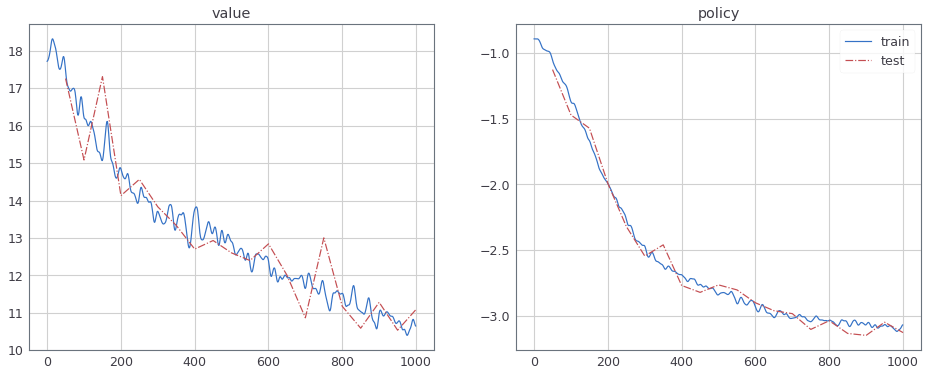

In [23]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 50
n_epochs = 2

def learn():
    for epoch in range(n_epochs):
        for batch in tqdm(env.train_dataloader):
            loss = ddpg.update(batch, learn=True)
            plotter.log_losses(loss)
            ddpg.step()
            if ddpg._step % plot_every == 0:
                clear_output(True)
                print('step', ddpg._step)
                test_loss = run_tests()
                plotter.log_losses(test_loss, test=True)
                plotter.plot_loss()
            if ddpg._step > 1000:
                return
            
learn()

# Update Functions
## Here is what's going on inside algo class

In [56]:
value_net  = recnn.nn.Critic(1290, 128, 256, 54e-2)
policy_net = recnn.nn.Actor(1290, 128, 256, 6e-1)
# these are target networks that we need for ddpg algorigm to work
target_value_net = recnn.nn.Critic(1290, 128, 256)
target_policy_net = recnn.nn.Actor(1290, 128, 256)

target_policy_net.eval()
target_value_net.eval()


# soft update
recnn.utils.soft_update(value_net, target_value_net, soft_tau=1.0)
recnn.utils.soft_update(policy_net, target_policy_net, soft_tau=1.0)

# define optimizers
value_optimizer = recnn.optim.RAdam(value_net.parameters(),
                              lr=1e-5, weight_decay=1e-2)
policy_optimizer = recnn.optim.RAdam(policy_net.parameters(), lr=1e-5 , weight_decay=1e-2)

nets = {
    'value_net': value_net.to(cuda),
    'target_value_net': target_value_net.to(cuda),
    'policy_net': policy_net.to(cuda),
    'target_policy_net': target_policy_net.to(cuda),
}

optimizer = {
    'policy_optimizer': policy_optimizer,
    'value_optimizer':  value_optimizer
}

debug = {}
writer = recnn.utils.misc.DummyWriter()


In [58]:
step = 0
params = {
    'gamma'      : 0.99,
    'min_value'  : -10,
    'max_value'  : 10,
    'policy_step': 10,
    'soft_tau'   : 0.001,
}
batch = {'state': state, 'action': action, 'reward': reward, 'next_state': next_state, 'done':done}
loss = recnn.nn.update.ddpg_update(batch, params, nets, optimizer, cuda, debug, writer, step=step)
print(loss)

{'value': 16.878826141357422, 'policy': -0.8092701435089111, 'step': 0}


## Training Loop
Let's wrap this thing in the training loop. I also will use Colab's gpu for training.

In an error pops up, go to runtime -> change runtime type -> select GPU. And also restart the session.

In [59]:
cuda = torch.device('cuda')
loss = {
    'test': {'value': [], 'policy': [], 'step': []},
    'train': {'value': [], 'policy': [], 'step': []}
    }

plotter = recnn.utils.Plotter(loss, [['value', 'policy']],)

In [60]:
# test function
def run_tests():
    batch = next(iter(env.test_dataloader))
    loss = recnn.nn.ddpg_update(batch, params, nets, optimizer,
                       cuda, debug, writer, step=step, learn=False)
    return loss

step 1000


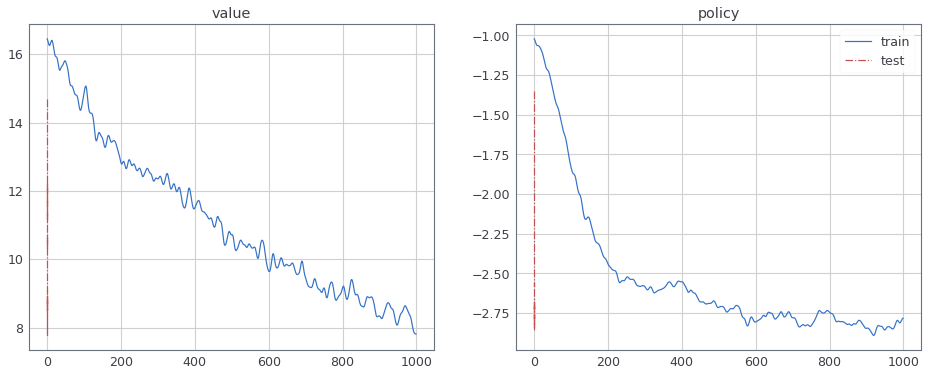

In [61]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

plot_every = 50
n_epochs = 2

def learn():
    step = 0
    for epoch in range(n_epochs):
        for batch in tqdm(env.train_dataloader):
            loss = recnn.nn.ddpg_update(batch, params,
                                               nets, optimizer, cuda, debug,
                                               writer, step=step)
            plotter.log_losses(loss)
            step += 1
            if step % plot_every == 0:
                clear_output(True)
                print('step', step)
                test_loss = run_tests()
                plotter.log_losses(test_loss, test=True)
                plotter.plot_loss()
            if step > 1000:
                return
            
        
learn()

In [62]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            print('plotting', n)
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

plotting linear1.weight
plotting linear2.weight
plotting linear3.weight


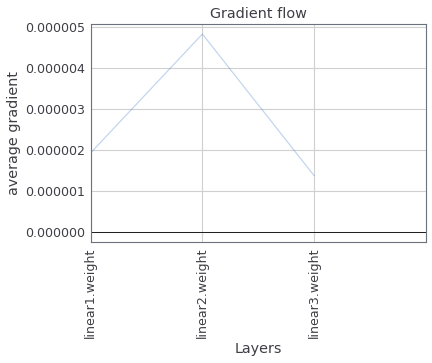

In [63]:
plot_grad_flow(ddpg.nets['policy_net'].named_parameters())